<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-study-1.2.1:-PCA---Identifying-Faces" data-toc-modified-id="Case-study-1.2.1:-PCA---Identifying-Faces-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case study 1.2.1: PCA - Identifying Faces</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Utility-functions" data-toc-modified-id="Utility-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Utility functions</a></span></li></ul></li><li><span><a href="#Image-preprocessing" data-toc-modified-id="Image-preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Image preprocessing</a></span></li><li><span><a href="#Calculating-the--&quot;eigenfaces&quot;" data-toc-modified-id="Calculating-the--&quot;eigenfaces&quot;-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculating the  "eigenfaces"</a></span></li><li><span><a href="#Reconstructing-and-classifying-new-faces" data-toc-modified-id="Reconstructing-and-classifying-new-faces-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reconstructing and classifying new faces</a></span></li></ul></div>

# Case study 1.2.1: PCA - Identifying Faces

---
<br>
__Useful resources:__

* Case study guide
* Original paper by Matthew A. Turk and Alex P. Pentland: [Face Recognition Using Eigenfaces](http://www.mit.edu/~9.54/fall14/Classes/class10/Turk%20Pentland%20Eigenfaces.pdf)
* Case study from JHU: [Eigenfaces for Face Detection/Recognition](http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf) 
* Blog entries:
    * [EigenFaces and A Simple Face Detector with PCA/SVD in Python](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)
    * [How to Get Eigenfaces](https://medium.com/@lwj.liuwenjing/how-to-get-eigenfaces-a9caeeba8767) ([source code](https://colab.research.google.com/drive/1T3cSvQZjKhh8s3Dxrb9gPCWhwhcz4Bmo#scrollTo=q2mPsa4M3Jkc))
    * [Eigenfaces: Recovering Humans from Ghosts](https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184)
    
<br>

---


Notebook setup:

In [1]:
import numpy as np
from sklearn.preprocessing import normalize
import os

#Visualization
import matplotlib.pyplot as plt
import skimage
from skimage import io, color, transform, exposure

# Data

---
<br>
In this case study example we are going to be using a public dataset called [LFWcrop](http://conradsanderson.id.au/lfwcrop/), by Conrad Sanderson. This dataset is a subsample of a bigger dataset called [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW).

The dataset consists of a series of 64x64 pixel images of faces, that have been cropped so that the face is at the center of the image.

The gray version of the dataset can be found in `Data/lfwcrop_grey_faces`.

<br>

---


The dataset contains more than one pictures of certain individuals. We build our training set with 100 (M) pictures of __different__ people. Different training set sizes can be explored.

In [2]:
irow,icol = (64,64)
dir_='Data/lfwcrop_grey_faces'
filenames=os.listdir(dir_)
print('Available images: {}'.format(len(filenames)))

#number of images on the training set.
M = 100
print('Trainig set size: {} images'.format(M))

img_name_list = []
k = 0
for i in range(M):
    img = False
    while not img:
        if filenames[k].find('_0001') >= 0:
            img_name_list.append(filenames[k])
            img = True
        k += 1

Available images: 13233
Trainig set size: 100 images


We can then import the pictures, flatten them (taking a N1xN2 matrix of pixel values and reshaping it into a (N1\*N2)-long vector) and store them in a matrix (`S_raw`).

In [3]:
S_raw = np.ndarray((icol*irow,M))
for i in range(M):
    #Reading img
    img = io.imread('Data/lfwcrop_grey_faces/{}'.format(img_name_list[i]))  
    img = color.rgb2gray(img)
    img = transform.resize(img, (irow,icol),anti_aliasing=True)
    #Adding img to the collection
    S_raw[:,i]= img.flatten()
#S_raw = skimage.img_as_ubyte(S_raw)
print('Dims of S_raw: {}'.format(S_raw.shape))
print('S_raw dtype: {}'.format(S_raw.dtype))

Dims of S_raw: (4096, 100)
S_raw dtype: float64


## Utility functions

Some utility functions for plotting and saving images throughout case study

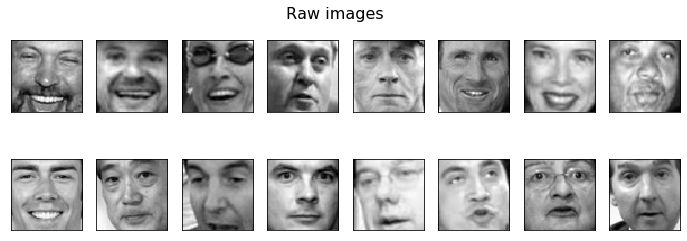

In [4]:
def plot_images(S,title=''):
    S = S[:,:16].copy()
    fig, axes = plt.subplots(nrows=round(S.shape[1]/8), ncols=8,figsize=(12,4))
    plt.subplots_adjust(wspace = 0.2,hspace = 0.2)
    ax = axes.ravel()
    fig.suptitle(title, fontsize = 16, y=0.95)
    for i in range(S.shape[1]):    
        #Plotting img
        ax[i].imshow(S[:,i].reshape((irow,icol)), cmap='gray') 
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False) 
    plt.show()

plot_images(S_raw,title='Raw images')

In [5]:
def save_images(S,directory=''):
    for i in range(S.shape[1]):
        io.imsave('Data/{}{}.jpg'.format(directory,i),S[:,i].reshape((irow,icol)))

# Image preprocessing


In order to condition the training set it is a good practice to normalize (get all the images to have the same mean and standard deviation) and center (substract the average of all images, to each of them) each image.

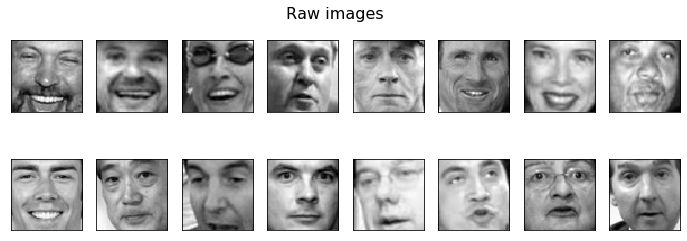

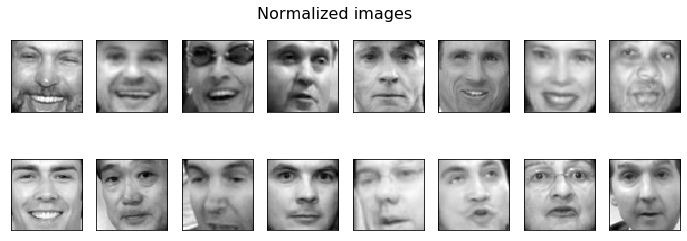

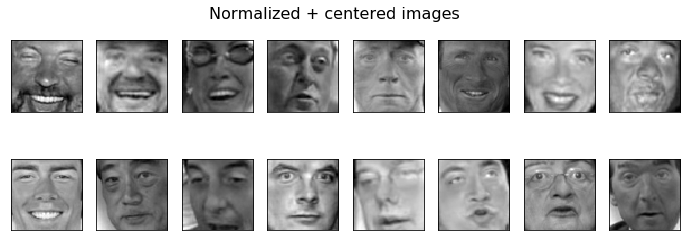

In [6]:
S_processed = S_raw.copy()
plot_images(S_raw,title='Raw images')
#Normalization
um = S_processed.mean(axis=1)
ustd = S_processed.std(axis=1)
for i in range(M):
    S_processed[:,i] = (S_processed[:,i] - S_processed[:,i].mean()) * ustd/S_processed[:,i].std() + um
    
plot_images(S_processed,title='Normalized images')

#Centering
mean_img = S_processed.mean(axis= 1)
for i in range(M):    
    S_processed[:,i] = S_processed[:,i] - mean_img

plot_images(S_processed,title = 'Normalized + centered images')
#save_images(S_processed, directory='preprocessed/')

We can also visualize the "mean face":

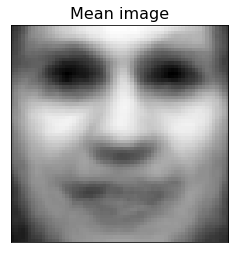

In [7]:
ax,fig = plt.subplots()
plt.imshow(skimage.img_as_ubyte(mean_img.reshape((irow,icol))), cmap='gray')
plt.title('Mean image',fontsize= 16)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False) 
plt.show()

# Calculating the  "eigenfaces"

The _eigenfaces_ are the eigenvectors of the dataset covariance matrix. 

Let A be our set of faces (flattened and centered by subtracting the mean). Then the covariance matrix C is calculated as C = AA<sup>T</sup>. However this a very large (N<sup>2</sup>xN<sup>2</sup>) matrix, and can be very computationally expensive to calculate it. Therefore we consider matrix L = A<sup>T</sup>A, which is a much smaller (MxM) matrix, and whose M eigenvectors (and corresponding eigenvalues) allow the calculation of the eigenvectors of C corresponding to the M biggest eigenvalues: 


In [8]:
#Covariance matrix C=AA'
#We calculate L=A'A cause C is too large
print('Calculating L = A\'A...')
A = S_processed.copy()
L = np.matmul(A.T,A)
print('Dims of L: {}\n'.format(L.shape))

#Calculating eigenvectors and eigen values of L
#np.linalg.eig() returns already normalized eigenvectors
print('Calculating eigenvectors and eigenvalues of L...')
dd, vv = np.linalg.eig(L)
#vv are the eigenvectors for L
#dd are the eigenvalues for both L and C
print('Dims of eigenvector set vv: {}'.format(vv.shape))
print('||vv_0||= {} (already normalized)\n'.format(np.linalg.norm(vv[:,0])))
#Eliminating eigenvectors with eigenvalue ≈ 0
print('Eliminating null eigenvalues (and corresponding eigenvectors)\n')
threshold = 1e-4
n = sum(dd > threshold)
d = np.zeros(n)
v = np.zeros((vv.shape[0],n))
j = 0
for i in range(len(dd)):
    if dd[i] > threshold:
        d[j] = dd[i]
        v[:,j] = vv[:,i]
        j += 1
    else:
        print('Deleting dd[{}] and vv[{}] (dd[{}]={})'.format(i,i,i,dd[i]))
#Sorting (ascending)
v = v[:,np.argsort(d)]
d = np.sort(d)
print('||v_0||= {} (already normalized)\n'.format(np.linalg.norm(v[:,0])))

#Eigenvectors of matrix C 
print('Calculating the {} higher eigenvectors and eigenvalues of C = AA\' (covariance matrix)...'.format(n))
u = np.matmul(A,v) 
print('Dims of u: {}'.format(u.shape))
#Normalization 
print('||u_0||= {}\n'.format(np.linalg.norm(u[:,0])))

print('Normalizing C matrix eigenvectors...')
u = normalize(u, axis = 0)
print('||u_0||= {}'.format(np.linalg.norm(u[:,0])))


Calculating L = A'A...
Dims of L: (100, 100)

Calculating eigenvectors and eigenvalues of L...
Dims of eigenvector set vv: (100, 100)
||vv_0||= 0.9999999999999999 (already normalized)

Eliminating null eigenvalues (and corresponding eigenvectors)

Deleting dd[41] and vv[41] (dd[41]=-5.684341886080802e-14)
||v_0||= 1.0 (already normalized)

Calculating the 99 higher eigenvectors and eigenvalues of C = AA' (covariance matrix)...
Dims of u: (4096, 99)
||u_0||= 2.239375549679569

Normalizing C matrix eigenvectors...
||u_0||= 0.9999999999999993


Once we have the eigenvectors u<sub>i</sub>, reshaping them as our original NxN images creates the _eigenfaces_.

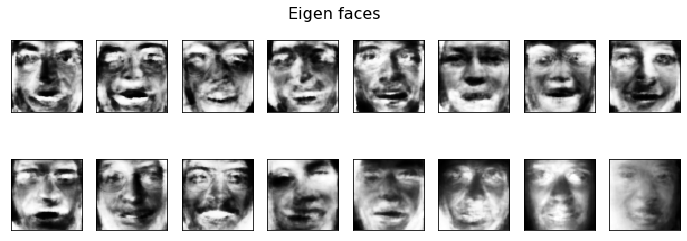

In [9]:
#Showing the eigenfaces
eigen_faces = np.ndarray((icol*irow,u.shape[1]))
for i in range(u.shape[1]):
    eigen_faces[:,i] = exposure.equalize_hist(u[:,i],nbins=256)
eigen_faces = skimage.img_as_ubyte(eigen_faces)
plot_images(eigen_faces[:,-16:],title = 'Eigen faces')
#save_images(eigen_faces,directory='eigenfaces/')

# Reconstructing and classifying new faces


One possible application of the _eigenfaces_ is reconstructing unseen images (images that are not in the training set). We take 16 images from the dataset that hadn't been included in the training set, but that belong to people that are in the training set. 

In [10]:
#Test set length
T = 16
test_img = []
i = 0
while 1:
    if (img_name_list[i][:-5] + '2.pgm') in filenames:
        test_img.append(img_name_list[i][:-5] + '2.pgm')
        if len(test_img) == T:
            break
    i += 1

We can then reconstruct them as a linear combination of the eigenfaces:

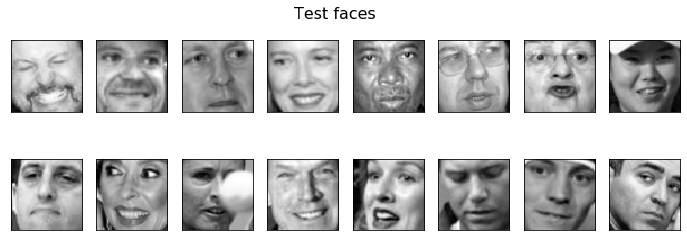

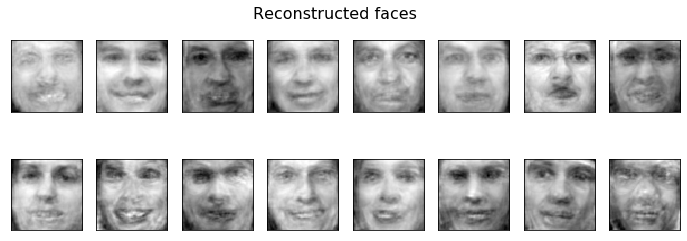

In [11]:
#Importing test set
S_test_raw = np.ndarray((icol*irow,T))
for i in range(T):
    #Reading img
    img = io.imread('Data/lfwcrop_grey_faces/{}'.format(test_img[i]))  
    img = color.rgb2gray(img)
    img = transform.resize(img, (irow,icol),anti_aliasing=True)
    #Adding img to the collection
    S_test_raw[:,i]= img.flatten()

#Normalization
S_test = S_test_raw.copy()
for i in range(T):
    S_test[:,i] = (S_test[:,i] - S_test[:,i].mean()) * ustd/S_test[:,i].std() + um

#Centering
for i in range(T):    
    S_test[:,i] = S_test[:,i] - mean_img

S_reshaped = np.ndarray((icol*irow,T))
for i in range(T):
    S_reshaped[:,i] = mean_img + np.dot(np.dot(u.T,S_test[:,i]),u.T)
    
#plot the both input and reconstructed images
plot_images(S_test_raw,title = 'Test faces')
plot_images(S_reshaped,title = 'Reconstructed faces')

We can also find how different each image of the test set is from the images in the training set:

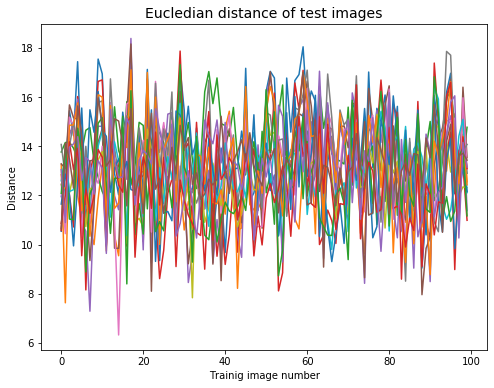

In [12]:
#Compute the weights of the eigenfaces in the new image
weights = np.zeros((u.shape[1],T))    
for i in range(T):
    weights[:,i] = np.dot(u.T,S_test[:,i])

omega = np.zeros((u.shape[1],A.shape[1]))
for h in range(A.shape[1]):
    omega[:,h] = np.dot(u.T, A[:,h].T)

#Find distance
e = np.zeros((omega.shape[1],T))
for i in range(T):
    for j in range(omega.shape[1]):
        diff_weight = weights[:,i] - omega[:,j]
        e[j,i] = np.linalg.norm(diff_weight)

ax, fig = plt.subplots(figsize=(8,6))
plt.plot(e)
plt.title('Eucledian distance of test images',fontsize = 14)
plt.xlabel('Trainig image number')
plt.ylabel('Distance')
plt.show()

<br>

<br>

<br>

<br>

<br>

<br>

Created by Iñigo de la Maza. Contact: [idelamaza.com](https://idelamaza.github.io/)

<br>

<br>

<br>

In [3]:
## IGNORE THE CODE BELOW ##

#Getting names of imported libraries and versions for creating a requirements.txt file
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
requirements.append(('scikit-image', '0.17.2'))    
#Getting the packages already included in requirements.txt
with open(r"../../requirements.txt", "r") as f:
    pkgs = [pkg.split('==')[0] for pkg in f.readlines()]
#Adding missing packages
print('List of packages and versions:\n')     
with open(r"../../requirements.txt", "a") as f:
    for r in requirements:
        print("{}=={}".format(*r))
        if r[0] not in pkgs:
            f.write("{}=={}\n".format(*r))

List of packages and versions:

numpy==1.18.1
matplotlib==3.1.3
scikit-image==0.17.2
